In [1]:
from pysb import *
from pysb.export import export
from pysb.bng import generate_network, generate_equations
from pysb.pathfinder import set_path
from pysb.simulator import ScipyOdeSimulator, BngSimulator
from pylab import linspace, plot, xlabel, ylabel, show

import seaborn
import matplotlib.pyplot as plt

palette = seaborn.color_palette('colorblind')

set_path('bng', '/shared/D1/opt/git-repositories/bionetgen.RuleWorld/bng2/')
# set_path('bng', '/opt/git-repositories/bionetgen.RuleWorld/bng2/')

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
Model()

<Model '_interactive_' (monomers: 0, rules: 0, parameters: 0, expressions: 0, compartments: 0) at 0x7f8428847b38>

In [3]:
Monomer('met', ['name', 'loc'], 
        { 'name' : ['alpha_lactose', 'beta_lactose', 'proton'], 'loc' : ['cyt', 'per']})

Monomer('cplx', ['name'], { 'name' : ['LACY_MONOMER'] })

Monomer('cplx', ['name'], {'name': ['LACY_MONOMER']})

In [4]:
Observable('obs_alpha_lactose_cyt', met(name = 'alpha_lactose', loc = 'cyt'))
Observable('obs_alpha_lactose_per', met(name = 'alpha_lactose', loc = 'per'))
Observable('obs_beta_lactose_cyt', met(name = 'beta_lactose', loc = 'cyt'))
Observable('obs_beta_lactose_per', met(name = 'beta_lactose', loc = 'per'))

Initial(cplx(name='LACY_MONOMER'), Parameter('t0__', 1))
Initial(met(name = 'alpha_lactose', loc = 'per'), Parameter('t0', 100))
Initial(met(name = 'beta_lactose', loc = 'cyt'), Parameter('t0__cd', 100))
Initial(met(name = 'proton', loc = 'per'), Parameter('t0_', 100))

Initial(met(name='proton', loc='per'), t0_)

In [5]:
Rule('LACTOSE_MUTAROTATION', met(name = 'alpha_lactose') | met(name = 'beta_lactose'), 
     Parameter('fwd_LACTOSE_MUTAROTATION', 1), Parameter('rsv_LACTOSE_MUTAROTATION', 1))

Rule('LACTOSE_MUTAROTATION', met(name='alpha_lactose') | met(name='beta_lactose'), fwd_LACTOSE_MUTAROTATION, rsv_LACTOSE_MUTAROTATION)

In [6]:
with open('Model1 - lactose mutarotation.kappa', 'w') as outfile:
    outfile.write(export(model, 'kappa'))

In [7]:
generate_network(model)
generate_equations(model)

In [8]:
runs = 20
# data1 = ScipyOdeSimulator(model, linspace(0, 100, 200)).run().dataframe
data1 = BngSimulator(model, linspace(0, 2, 201)).run(method = 'ode').dataframe
data2 = BngSimulator(model, linspace(0, 2, 201)).run(method = 'ssa', n_runs = runs).dataframe

data = []
for i in range(0,runs):
    data.append(data2.xs(i))

avrg = 0
for i in range(0,runs):
    avrg += data[i]
avrg = avrg / runs

stdv = []
for i in range(0,runs):
    stdv = (data[i] - avrg)**2
stdv = (stdv / (runs-1))**0.5

data2 = data[0]

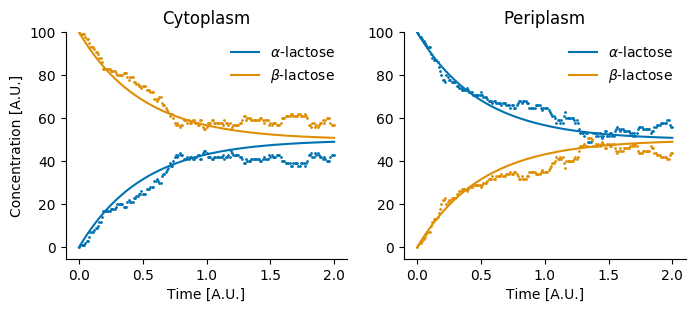

In [9]:
fig, ax = plt.subplots(1, 2, figsize = (4*2, 3*1), dpi = 100)

ax[0].plot(data1.index, data1['obs_alpha_lactose_cyt'], label = r'$\alpha$-lactose', c = palette[0])
ax[0].plot(data1.index, data1['obs_beta_lactose_cyt'], label = r'$\beta$-lactose', c = palette[1])
ax[0].scatter(data2.index, data2['obs_alpha_lactose_cyt'], s = 1, color = palette[0])
ax[0].scatter(data2.index, data2['obs_beta_lactose_cyt'], s = 1, color = palette[1])

ax[1].plot(data1.index, data1['obs_alpha_lactose_per'], label = r'$\alpha$-lactose', c = palette[0])
ax[1].plot(data1.index, data1['obs_beta_lactose_per'], label = r'$\beta$-lactose', c = palette[1])
ax[1].scatter(data2.index, data2['obs_alpha_lactose_per'], s = 1, color = palette[0])
ax[1].scatter(data2.index, data2['obs_beta_lactose_per'], s = 1, color = palette[1])

ax[0].set_xlabel('Time [A.U.]')
ax[0].set_ylabel('Concentration [A.U.]')
ax[0].set_title('Cytoplasm')
ax[0].set_ylim(top = 100)

ax[1].set_xlabel('Time [A.U.]')
ax[1].set_title('Periplasm')
ax[1].set_ylim(top = 100)

ax[0].legend(frameon = False)
ax[1].legend(frameon = False)

seaborn.despine()

plt.savefig('mutarotation_lactose.png', format = 'png', bbox_inches = 'tight', dpi = 300)

plt.show()

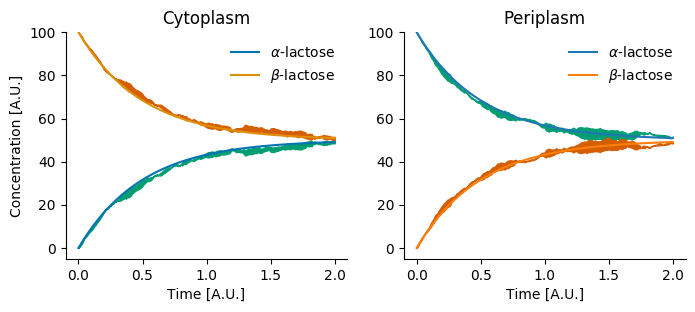

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (4*2, 3*1), dpi = 100)

ax[0].plot(data1.index, data1['obs_alpha_lactose_cyt'], label = r'$\alpha$-lactose', c = palette[0])
ax[0].plot(data1.index, data1['obs_beta_lactose_cyt'], label = r'$\beta$-lactose', c = palette[1])
ax[0].fill_between(avrg.index, 
                   avrg['obs_alpha_lactose_cyt'] + stdv['obs_alpha_lactose_cyt'], 
                   avrg['obs_alpha_lactose_cyt'] - stdv['obs_alpha_lactose_cyt'], **{'color' : palette[2]})
ax[0].fill_between(avrg.index, 
                   avrg['obs_beta_lactose_cyt'] + stdv['obs_beta_lactose_cyt'], 
                   avrg['obs_beta_lactose_cyt'] - stdv['obs_beta_lactose_cyt'], **{'color' : palette[3]})

ax[1].plot(data1.index, data1['obs_alpha_lactose_per'], label = r'$\alpha$-lactose')
ax[1].plot(data1.index, data1['obs_beta_lactose_per'], label = r'$\beta$-lactose')
ax[1].fill_between(avrg.index, 
                   avrg['obs_alpha_lactose_per'] + stdv['obs_alpha_lactose_per'], 
                   avrg['obs_alpha_lactose_per'] - stdv['obs_alpha_lactose_per'], **{'color' : palette[2]})
ax[1].fill_between(avrg.index, 
                   avrg['obs_beta_lactose_per'] + stdv['obs_beta_lactose_per'], 
                   avrg['obs_beta_lactose_per'] - stdv['obs_beta_lactose_per'], **{'color' : palette[3]})

ax[0].set_xlabel('Time [A.U.]')
ax[0].set_ylabel('Concentration [A.U.]')
ax[0].set_title('Cytoplasm')
ax[0].set_ylim(top = 100)

ax[1].set_xlabel('Time [A.U.]')
ax[1].set_title('Periplasm')
ax[1].set_ylim(top = 100)

ax[0].legend(frameon = False)
ax[1].legend(frameon = False)

seaborn.despine()

plt.savefig('mutarotation_lactose_stdv.png', format = 'png', bbox_inches = 'tight', dpi = 300)

plt.show()